# Double-Slit experiment using Crank-Nichsolson scheme to solve 2D Schrödinger equation numerically for Gaussian Wave packet hitting a potential barrier

hbarquanta

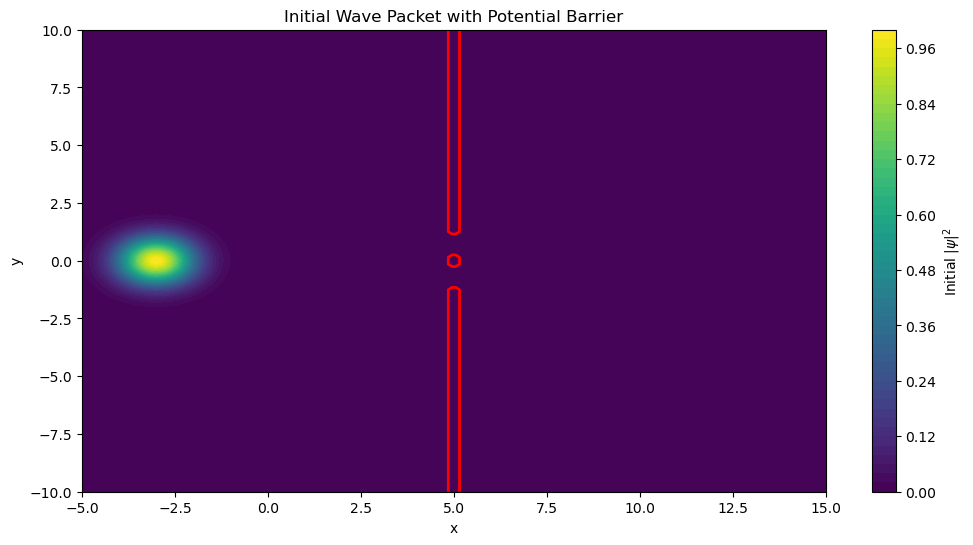

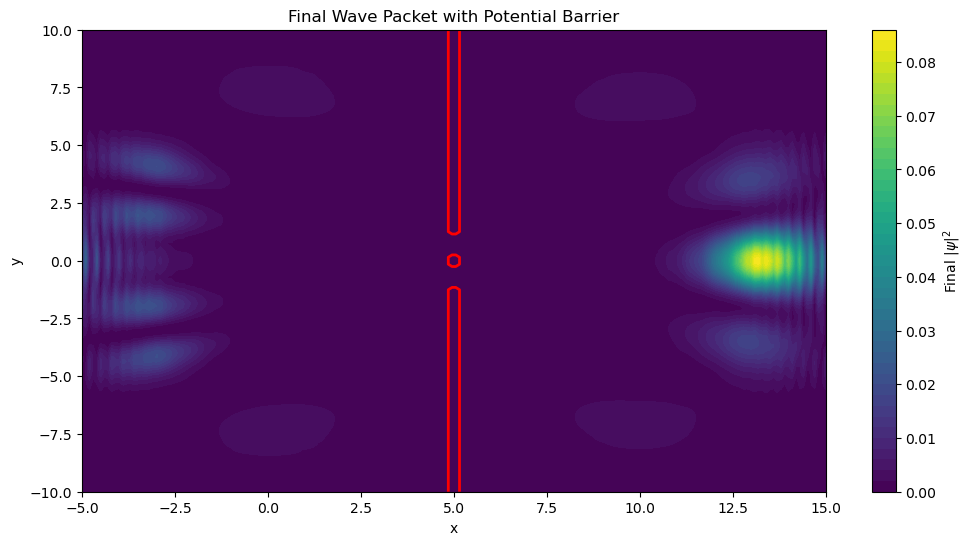

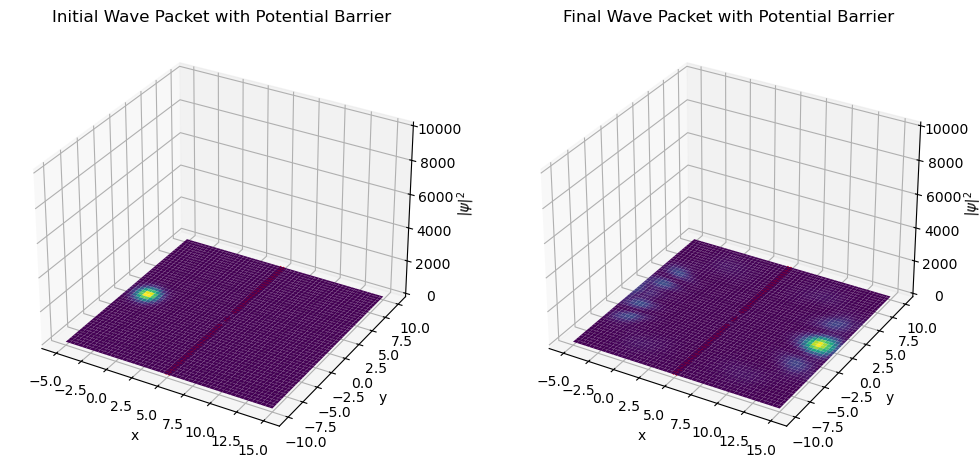

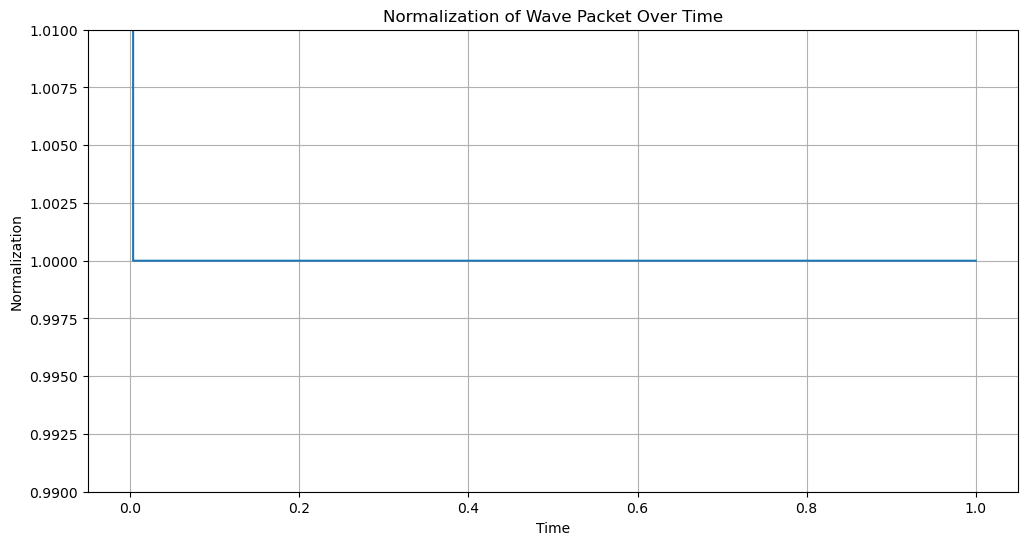

/var/folders/hb/cgmm688j7q51h1ygk7wzt9fh0000gn/T/ipykernel_26703/4253303688.py:163: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  return contour.collections
/var/folders/hb/cgmm688j7q51h1ygk7wzt9fh0000gn/T/ipykernel_26703/4253303688.py:163: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  return contour.collections


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags
from scipy.sparse.linalg import splu
from matplotlib.animation import FuncAnimation, PillowWriter
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import HTML

# Parameters
x_min, x_max = -5, 15
y_min, y_max = -10, 10
nx, ny = 200, 200  # Number of spatial points
dx = (x_max - x_min) / (nx - 1)
dy = (y_max - y_min) / (ny - 1)
x = np.linspace(x_min, x_max, nx)
y = np.linspace(y_min, y_max, ny)
X, Y = np.meshgrid(x, y)

t_min, t_max = 0, 1
nt = 300  # Number of time steps
dt = (t_max - t_min) / (nt - 1)
times = np.linspace(t_min, t_max, nt)

k0x, k0y = 10, 0
delta_k = 1

# Potential parameters for double slit
def double_slit_potential(x, y, d, b):
    """Create double slit potential at x=5 with slits centered at y=-d/2 and y=d/2, each of width b."""
    V = np.zeros_like(X)
    slit_center_1 = -d / 2
    slit_center_2 = d / 2

    for i in range(nx):
        if np.isclose(x[i], 5, atol=dx):
            for j in range(ny):
                if not ((slit_center_1 - b / 2 < y[j] < slit_center_1 + b / 2) or 
                        (slit_center_2 - b / 2 < y[j] < slit_center_2 + b / 2)):
                    V[j, i] = 10000  # Large potential to simulate wall
    return V

d = 1.5  # Slit spacing
b = 1.0  # Slit width
V = double_slit_potential(x, y, d, b)

def initial_wave_packet(x, y, x0, y0, k0x, k0y, sigma_x, sigma_y):
    """Initial wave packet (Gaussian) centered at (x0, y0) with momentum (k0x, k0y)."""
    return (np.exp(-((x - x0)**2 / (2 * sigma_x**2) + (y - y0)**2 / (2 * sigma_y**2))) *
            np.exp(1j * (k0x * x + k0y * y)))

# Parameters for the wave packet
x0, y0 = -3, 0  # Initial position
sigma_x, sigma_y = 1.0, 1.0  # Width of the Gaussian packet
k0x, k0y = 10, 0.0  # Initial momentum

# Initialize wave packet
psi_0 = initial_wave_packet(X, Y, x0, y0, k0x, k0y, sigma_x, sigma_y).flatten()

def create_tridiagonal_matrix(nx, ny, rx, ry, V):
    """Create tridiagonal matrix A and B for Crank-Nicholson"""
    main_diag = 1 + 2 * (rx + ry) + 1j * dt * V.flatten() / 2
    off_diag_x = -rx
    off_diag_y = -ry
    diagonals = [off_diag_x, off_diag_x, main_diag, off_diag_y, off_diag_y]
    A = diags(diagonals, [-ny, -1, 0, 1, ny], shape=(nx * ny, nx * ny), format='csc')
    B = diags([-off_diag_x, -off_diag_x, main_diag.conjugate(), -off_diag_y, -off_diag_y], [-ny, -1, 0, 1, ny], shape=(nx * ny, nx * ny), format='csc')
    return A, B

def crank_nicholson_step(A, B, psi, lu):
    """Perform one time step using the Crank-Nicholson scheme"""
    rhs = B @ psi
    psi_next = lu.solve(rhs)
    return psi_next

def compute_normalization(psi, dx, dy):
    """Compute the normalization of the wave function"""
    return np.sum(np.abs(psi)**2) * dx * dy

# Crank-Nicholson matrices
rx = 1j * dt / (2 * dx**2)
ry = 1j * dt / (2 * dy**2)
A, B = create_tridiagonal_matrix(nx, ny, rx, ry, V)

# LU decomposition of A
lu = splu(A)

# Time evolution
psi = psi_0.copy()
psis = [psi.copy()]
normalizations = [compute_normalization(psi, dx, dy)]

for _ in range(nt):
    psi = crank_nicholson_step(A, B, psi, lu)
    psi /= np.sqrt(compute_normalization(psi, dx, dy))  # Normalize the wave function
    psis.append(psi.copy())
    normalizations.append(compute_normalization(psi, dx, dy))

psis = np.array(psis)

def plot_initial_final_wave_packet_2d(X, Y, psis, nx, ny, V):
    """Plot the initial and final wave packet in 2D with potential barriers"""
    plt.figure(figsize=(12, 6))
    plt.contourf(X, Y, np.abs(psis[0].reshape((nx, ny)))**2, levels=50, cmap='viridis')
    plt.colorbar(label=r'Initial $|\psi|^2$')
    plt.contour(X, Y, V, levels=[1], colors='red', linewidths=2)  # Plot potential barrier
    plt.title('Initial Wave Packet with Potential Barrier')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()
    
    plt.figure(figsize=(12, 6))
    plt.contourf(X, Y, np.abs(psis[-1].reshape((nx, ny)))**2, levels=50, cmap='viridis')
    plt.colorbar(label=r'Final $|\psi|^2$')
    plt.contour(X, Y, V, levels=[1], colors='red', linewidths=2)  # Plot potential barrier
    plt.title('Final Wave Packet with Potential Barrier')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()

def plot_initial_final_wave_packet_3d(X, Y, psis, nx, ny, V):
    """Plot the initial and final wave packet in 3D with potential barriers"""
    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(121, projection='3d')
    ax.plot_surface(X, Y, np.abs(psis[0].reshape((nx, ny)))**2, cmap='viridis')
    ax.contour(X, Y, V, levels=[1], colors='red', linestyles='solid', linewidths=2)  # Plot potential barrier
    ax.set_title('Initial Wave Packet with Potential Barrier')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel(r'$|\psi|^2$')
    
    ax = fig.add_subplot(122, projection='3d')
    ax.plot_surface(X, Y, np.abs(psis[-1].reshape((nx, ny)))**2, cmap='viridis')
    ax.contour(X, Y, V, levels=[1], colors='red', linestyles='solid', linewidths=2)  # Plot potential barrier
    ax.set_title('Final Wave Packet with Potential Barrier')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel(r'$|\psi|^2$')
    plt.show()

def plot_normalization(times, normalizations):
    """Plot the normalization of the wave packet over time"""
    plt.figure(figsize=(12, 6))
    plt.plot(times, normalizations[:len(times)])  # Ensure same length
    plt.title('Normalization of Wave Packet Over Time')
    plt.xlabel('Time')
    plt.ylabel('Normalization')
    plt.ylim([0.99, 1.01])
    plt.grid(True)
    plt.show()

def create_animation_2d(X, Y, psis, nx, ny, V):
    """Create a 2D animation of the wave packet evolution with potential barriers"""
    fig, ax = plt.subplots()
    contour = ax.contourf(X, Y, np.abs(psis[0].reshape((nx, ny)))**2, levels=50, cmap='viridis')
    ax.set_ylim(y_min, y_max)
    ax.set_xlim(x_min, x_max)
    ax.contour(X, Y, V, levels=[1], colors='red', linewidths=2)  # Plot potential barrier
    
    def update(frame):
        ax.clear()
        contour = ax.contourf(X, Y, np.abs(psis[frame].reshape((nx, ny)))**2, levels=50, cmap='viridis')
        ax.contour(X, Y, V, levels=[1], colors='red', linewidths=2)  # Plot potential barrier
        return contour.collections
    
    ani = FuncAnimation(fig, update, frames=range(nt), blit=True)
    plt.close()
    return ani

def create_animation_3d(X, Y, psis, nx, ny, V):
    """Create a 3D animation of the wave packet evolution with potential barriers"""
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    def update(frame):
        ax.clear()
        surf = ax.plot_surface(X, Y, np.abs(psis[frame].reshape((nx, ny)))**2, cmap='viridis')
        ax.contour(X, Y, V, levels=[1], colors='red', linestyles='solid', linewidths=2)  # Plot potential barrier
        ax.set_zlim(0, 1)
        return surf,
    
    ani = FuncAnimation(fig, update, frames=range(nt), blit=True)
    plt.close()
    return ani

# Plot initial and final wave packet in 2D and 3D
plot_initial_final_wave_packet_2d(X, Y, psis, nx, ny, V)
plot_initial_final_wave_packet_3d(X, Y, psis, nx, ny, V)

# Plot normalization
plot_normalization(times, normalizations)

# Create and display 2D animation
ani_2d = create_animation_2d(X, Y, psis, nx, ny, V)
ani_2d.save("schrodinger_equation_2d_evolution_double_slit.gif", writer=PillowWriter(fps=10))

# Create and display 3D animation
ani_3d = create_animation_3d(X, Y, psis, nx, ny, V)
ani_3d.save("schrodinger_equation_3d_evolution_double_slit.gif", writer=PillowWriter(fps=10))

HTML("""
<h3>Time Evolution of 2D Wave Packet with Double Slit</h3>
<img src="schrodinger_equation_2d_evolution_double_slit.gif" style="width: 600px;">
<h3>Time Evolution of 2D Wave Packet in 3D with Double Slit</h3>
<img src="schrodinger_equation_3d_evolution_double_slit.gif" style="width: 600px;">
""")
